In [1]:
from sklearn.datasets import fetch_20newsgroups
import numpy as np

dataset = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'),
                             shuffle=True, random_state=42, )

print("%d documents" % len(dataset.data))
print("%d categories" % len(dataset.target_names))


18846 documents
20 categories


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from gensim.utils import simple_preprocess

df = pd.DataFrame({'text': dataset.data, 'target': dataset.target}).copy()
df['target_name'] = df.target.apply(lambda x: dataset.target_names[x])
df.text = df.text.apply(lambda x: ' '.join(simple_preprocess(x)))


In [3]:
df.isnull().sum()
print(df.text.values[0])
df.head()


am sure some bashers of pens fans are pretty confused about the lack of any kind of posts about the recent pens massacre of the devils actually am bit puzzled too and bit relieved however am going to put an end to non pittsburghers relief with bit of praise for the pens man they are killing those devils worse than thought jagr just showed you why he is much better than his regular season stats he is also lot fo fun to watch in the playoffs bowman should let jagr have lot of fun in the next couple of games since the pens are going to beat the pulp out of jersey anyway was very disappointed not to see the islanders lose the final regular season game pens rule


,text,target,target_name
0,am sure some bashers of pens fans are pretty c...,10,rec.sport.hockey
1,my brother is in the market for high performan...,3,comp.sys.ibm.pc.hardware
2,finally you said what you dream about mediterr...,17,talk.politics.mideast
3,think it the scsi card doing the dma transfers...,3,comp.sys.ibm.pc.hardware
4,have an old jasmine drive which cannot use wit...,4,comp.sys.mac.hardware


In [4]:
df['text_word_count'] = df['text'].apply(lambda x: np.log(len(x.split(" "))))

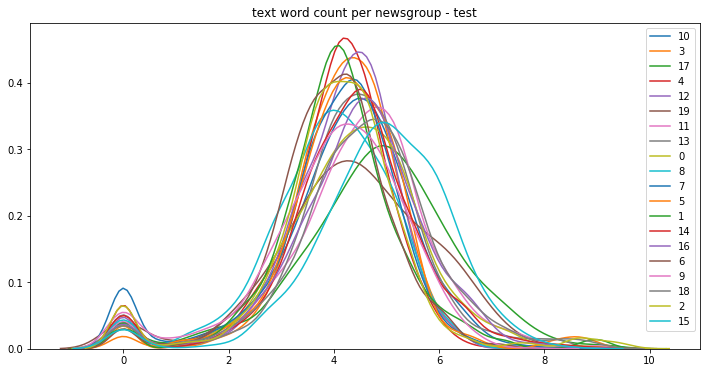

In [5]:
def plot_features_distribution_categories(feature, feature_sel, title, df):
    plt.figure(figsize=(12,6))
    plt.title(title)
    feature_sel_cat = list(df[feature_sel].unique())
    for feature_cat in feature_sel_cat:
        filter_df = df.loc[df[feature_sel] == feature_cat]        
        sns.distplot(filter_df[feature],kde=True,hist=False, bins=120, label=feature_cat)
    plt.xlabel('')
    plt.legend()
    plt.show()
    
plot_features_distribution_categories('text_word_count', 'target', 'text word count per newsgroup - test', df)

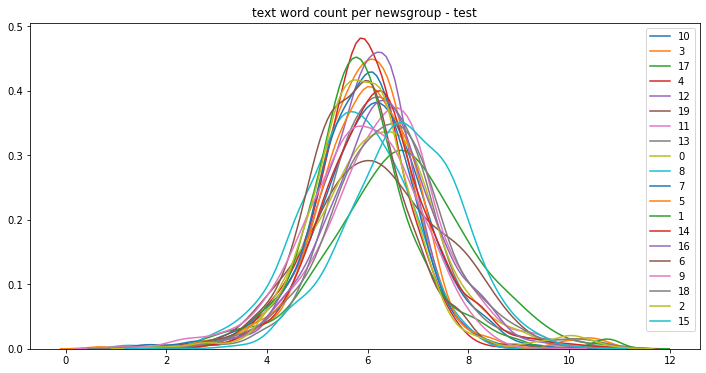

In [6]:
df['text_length'] = df['text'].apply(lambda x: np.log(len(x)))
plot_features_distribution_categories('text_length', 'target', 'text word count per newsgroup - test', df)

In [7]:
from wordcloud import WordCloud, STOPWORDS
from gensim.utils import simple_preprocess

stopwords = set(STOPWORDS)
def show_wordcloud(feature,df,title="",size=2):
    df[feature] = df[feature].apply(lambda x: ' '.join(simple_preprocess(x)))
    data = df.loc[~df[feature].isnull(), feature].values
    
    count = (~df[feature].isnull()).sum()
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=5,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(size*4, size*4))
    plt.axis('off')
    fig.suptitle("Top words in {} {} ({} rows)".format(title,feature,count), fontsize=np.sqrt(size)*15)
    fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()
    



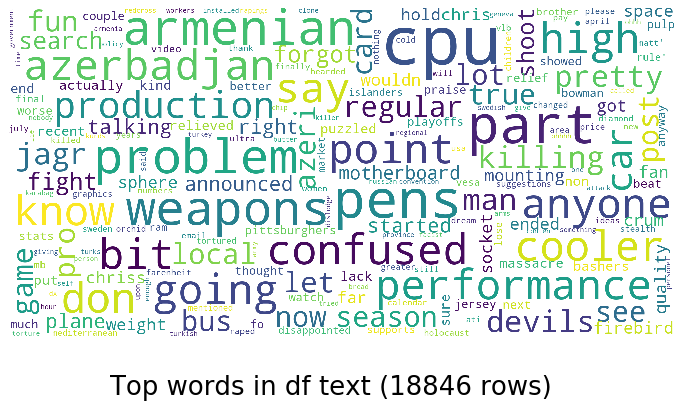

In [8]:
show_wordcloud('text',df, 'df',size=3)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


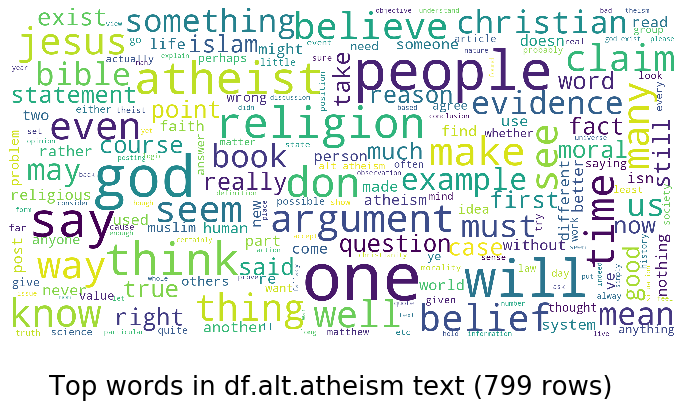

In [9]:
show_wordcloud('text',df.loc[df.target==0], 'df.' + dataset.target_names[0], size=3)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


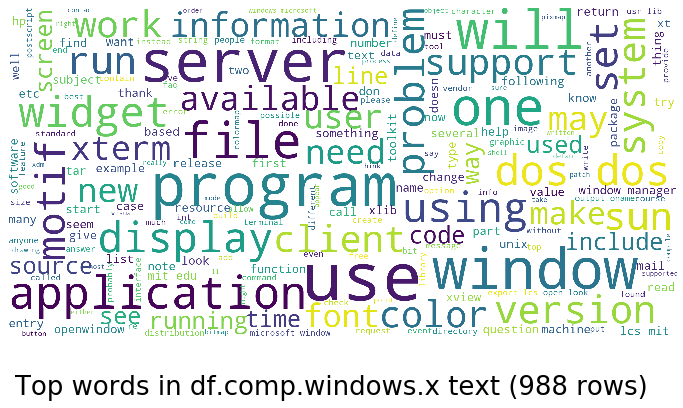

In [10]:
show_wordcloud('text',df.loc[df.target==5], 'df.' + dataset.target_names[5], size=3)

## KMeans + tf_idf

In [12]:
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.preprocessing import Normalizer
from sklearn import metrics
from sklearn.pipeline import make_pipeline


from sklearn.cluster import KMeans

labels = df.target
n_components = 20

vectorizer = TfidfVectorizer(stop_words='english', max_features=2000)
X = vectorizer.fit_transform(df['text'])

print("n_samples: %d, n_features: %d" % X.shape)
print("Performing dimensionality reduction using LSA")

svd = TruncatedSVD(30)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)
X = lsa.fit_transform(X)


km = KMeans(n_clusters=n_components, init='k-means++', max_iter=1000, n_init=1, verbose=False)
km.fit(X)


print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f"% metrics.adjusted_rand_score(labels, km.labels_))
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, km.labels_, sample_size=1000))

n_samples: 18846, n_features: 2000
Performing dimensionality reduction using LSA
Homogeneity: 0.293
Completeness: 0.298
V-measure: 0.295
Adjusted Rand-Index: 0.173
Silhouette Coefficient: 0.125


In [13]:
print("Top terms per cluster:")
original_space_centroids = svd.inverse_transform(km.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]


terms = vectorizer.get_feature_names()
for i in range(n_components):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()

Top terms per cluster:
Cluster 0: think don people say really like better believe right just
Cluster 1: car cars engine think new miles power drive know does
Cluster 2: like good just know sounds time does use new looks
Cluster 3: just don did got way good sure say people read
Cluster 4: don know want does people just ll use ve let
Cluster 5: drive scsi disk mb hard drives ide controller floppy dos
Cluster 6: com does mail use list modem phone address port know
Cluster 7: edu cs soon university article mail email apr ftp send
Cluster 8: game team games year season hockey players play win baseball
Cluster 9: god jesus believe bible christ faith christian christians sin people
Cluster 10: israel jews israeli people jewish armenian arab armenians war state
Cluster 11: card video monitor mb bit bus mhz cards use color
Cluster 12: new sale price offer mail condition shipping interested asking email
Cluster 13: government did right people fbi gun law said koresh batf
Cluster 14: key chip cli

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 18846 samples in 0.081s...
[t-SNE] Computed neighbors for 18846 samples in 44.486s...
[t-SNE] Computed conditional probabilities for sample 1000 / 18846
[t-SNE] Computed conditional probabilities for sample 2000 / 18846
[t-SNE] Computed conditional probabilities for sample 3000 / 18846
[t-SNE] Computed conditional probabilities for sample 4000 / 18846
[t-SNE] Computed conditional probabilities for sample 5000 / 18846
[t-SNE] Computed conditional probabilities for sample 6000 / 18846
[t-SNE] Computed conditional probabilities for sample 7000 / 18846
[t-SNE] Computed conditional probabilities for sample 8000 / 18846
[t-SNE] Computed conditional probabilities for sample 9000 / 18846
[t-SNE] Computed conditional probabilities for sample 10000 / 18846
[t-SNE] Computed conditional probabilities for sample 11000 / 18846
[t-SNE] Computed conditional probabilities for sample 12000 / 18846
[t-SNE] Computed conditional probabilities for s

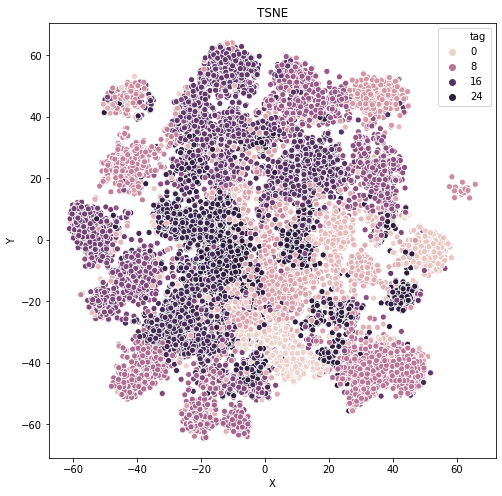

In [14]:
from sklearn.manifold import TSNE


tsne = TSNE(n_components = 2, perplexity= 50, verbose=1)
tsne_data = tsne.fit_transform(X, y = km.predict(X))
tsne_data = pd.DataFrame(tsne_data, columns = ['X', 'Y'])
tsne_data['tag'] = km.predict(X)


plt.figure(figsize=(8, 8))
sns.scatterplot(x = 'X', y = 'Y', hue=tsne_data['tag'], data = tsne_data ,sizes=(20, 300), cmap='viridis')
plt.title('TSNE')
plt.show()

In [15]:
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.preprocessing import Normalizer
from sklearn import metrics
from sklearn.pipeline import make_pipeline


from sklearn.cluster import KMeans, MiniBatchKMeans

labels = df.target
n_components = 20

vectorizer = TfidfVectorizer(stop_words='english', max_features=2000)
X = vectorizer.fit_transform(df['text'])

print("n_samples: %d, n_features: %d" % X.shape)
print("Performing dimensionality reduction using LSA")

svd = TruncatedSVD(30)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)
X = lsa.fit_transform(X)


km = MiniBatchKMeans(n_clusters=n_components, init='k-means++', max_iter=1000, n_init=1, verbose=False)
km.fit(X)


print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f"% metrics.adjusted_rand_score(labels, km.labels_))
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, km.labels_, sample_size=1000))

n_samples: 18846, n_features: 2000
Performing dimensionality reduction using LSA
Homogeneity: 0.277
Completeness: 0.283
V-measure: 0.280
Adjusted Rand-Index: 0.149
Silhouette Coefficient: 0.119


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 18846 samples in 0.044s...
[t-SNE] Computed neighbors for 18846 samples in 42.342s...
[t-SNE] Computed conditional probabilities for sample 1000 / 18846
[t-SNE] Computed conditional probabilities for sample 2000 / 18846
[t-SNE] Computed conditional probabilities for sample 3000 / 18846
[t-SNE] Computed conditional probabilities for sample 4000 / 18846
[t-SNE] Computed conditional probabilities for sample 5000 / 18846
[t-SNE] Computed conditional probabilities for sample 6000 / 18846
[t-SNE] Computed conditional probabilities for sample 7000 / 18846
[t-SNE] Computed conditional probabilities for sample 8000 / 18846
[t-SNE] Computed conditional probabilities for sample 9000 / 18846
[t-SNE] Computed conditional probabilities for sample 10000 / 18846
[t-SNE] Computed conditional probabilities for sample 11000 / 18846
[t-SNE] Computed conditional probabilities for sample 12000 / 18846
[t-SNE] Computed conditional probabilities for s

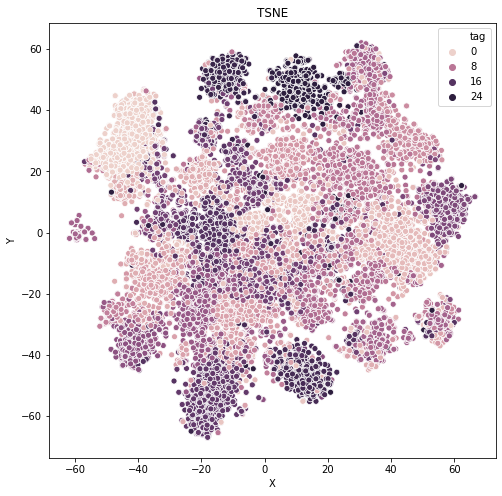

In [16]:
from sklearn.manifold import TSNE


tsne = TSNE(n_components = 2, perplexity= 50, verbose=1)
tsne_data = tsne.fit_transform(X, y = km.predict(X))
tsne_data = pd.DataFrame(tsne_data, columns = ['X', 'Y'])
tsne_data['tag'] = km.predict(X)


plt.figure(figsize=(8, 8))
sns.scatterplot(x = 'X', y = 'Y', hue=tsne_data['tag'], data = tsne_data ,sizes=(20, 300), cmap='viridis')
plt.title('TSNE')
plt.show()